In [1]:
from utils import *

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns
import folium

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error, accuracy_score

import optuna
from optuna.trial import TrialState

/home/guilhermemaciel/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Carregando o dataset

In [2]:
df_train = pd.read_csv('../data/treated_data/train.csv')
df_val = pd.read_csv('../data/treated_data/validation.csv')
df_test = pd.read_csv('../data/treated_data/test.csv')

Concatenando os datasets de treino e validação, pois o Random Forest não necessita de validação

In [3]:
df_train = pd.concat([df_train, df_val], ignore_index=False)

In [4]:
df_train.head()

ponto_id  rssi_1_1  rssi_1_2  rssi_1_3  rssi_2_1  rssi_2_2  rssi_2_3  \
0         7  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1      5532  0.182301  0.000000  0.180096  0.000000  0.171053  0.000000   
2      9607  0.456080  0.551300  0.418441  0.257431  0.403415  0.426501   
3      8265  0.532237  0.460564  0.534400  0.503367  0.787234  0.538737   
4      8008  0.536607  0.579895  0.498791  0.624933  0.614968  0.256754   

   rssi_3_1  rssi_3_2  rssi_3_3   delay_1   delay_2   delay_3       lat  \
0  0.317523  0.527387  0.000000  0.666667  0.428571  0.285714 -8.055605   
1  0.291003  0.352840  0.110150  0.666667  0.428571  0.285714 -8.055784   
2  0.336851  0.464357  0.326409  0.333333  0.428571  0.857143 -8.046460   
3  0.332463  0.405254  0.278578  0.500000  0.142857  0.571429 -8.051810   
4  0.452570  0.417102  0.278578  0.500000  0.142857  0.571429 -8.052220   

         lon  indoor  
0 -34.951728       1  
1 -34.951608       1  
2 -34.946220       0  
3 -34.948510       0  
4 -34.948150       0

In [5]:
X_train = df_train.drop(['ponto_id', 'indoor', 'lat', 'lon'], axis=1).values
y_train = df_train[['lat', 'lon']].values

X_test = df_test.drop(['ponto_id', 'indoor', 'lat', 'lon'], axis=1).values
y_test = df_test[['lat', 'lon']].values

In [6]:
model = RandomForestRegressor(
    n_estimators=10,
    max_depth=10,
    criterion='squared_error',
    min_samples_leaf=1,
    max_features=df_train.shape[1],
    random_state=51
)

In [7]:
model.fit(X=X_train, y=y_train)

RandomForestRegressor(max_depth=10, max_features=16, n_estimators=10,
                      random_state=51)

## Avaliando o modelo

#### Conjunto de Teste

In [8]:
y_pred_test_class = model.predict(X_test)

rmse = np.sqrt(root_mean_squared_error(y_test, y_pred_test_class))
print(f'RMSE: {rmse}')

RMSE: 0.010918785704412758


In [9]:
accuracy = calculate_accuracy(y_pred_test_class, y_test)
print(f"Acurácia: {accuracy:.3f}")


Acurácia: 0.838


Erro de localização médio, mínimo, máximo e desvio-padrão

In [10]:
distances = get_error_distances(y_pred_test_class, y_test)

In [11]:
print_errors(distances)

Erro de localização médio: 6.615 metros
Erro mínimo: 2.6357412197674757e-09 metros
Erro máximo: 180.066 metros
Desvio Padrão do erro: 17.529 metros


#### BoxPlot

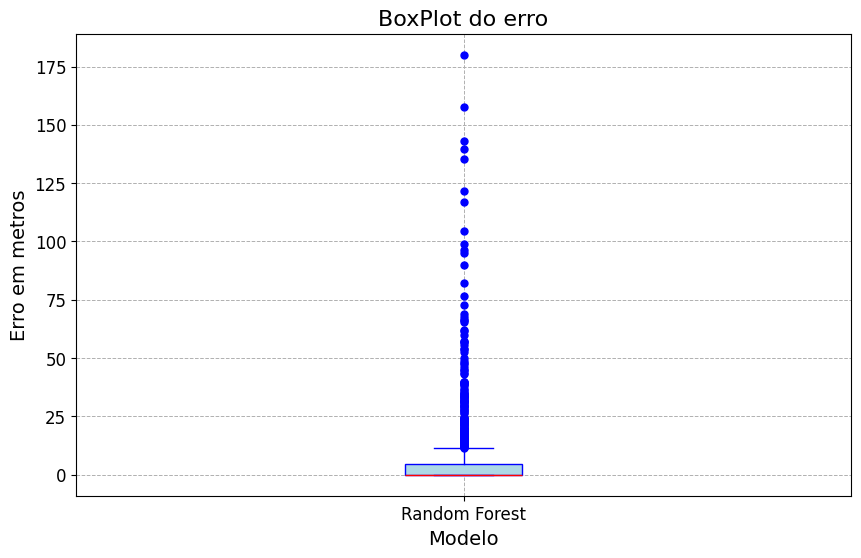

In [12]:
plot_boxplot('Random Forest', distances)

#### Visualização dos Mapas

In [13]:
map = plot_folium_map(y_test, y_pred_test_class, True)
map

In [14]:
map = plot_folium_map(y_test, y_pred_test_class, False)
map

#### Avaliando o modelos para pontos específicos 

In [15]:
# Prevendo o valor de uma instância específica
idx = 75

X_unit = X_test[idx].reshape(1, -1)
y_unit = np.array([y_test[idx]])
y_pred_unit = model.predict(X_unit)

print(f"Pred Point: {y_pred_unit[0]}")
print(f"Real Point: {y_unit[0]}")

Pred Point: [ -8.05537997 -34.95173596]
Real Point: [ -8.05538  -34.951736]


In [16]:
map = plot_folium_map(y_unit, y_pred_unit, True)
map

#### Usando o Optune para encontrar os melhores Hiperparâmetros

#### Primeiro iremos criar uma função objetivo, com foco em maximizar o AOC

In [17]:
def objective(trial):

    global x_train
    global y_train

    global X_test
    global y_test
    
    # Sugerir valores para os hiperparâmetros
    n_estimators = trial.suggest_int('n_estimators', 10, 500)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 15)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)

    trial.set_user_attr("n_estimators", n_estimators)
    trial.set_user_attr("max_depth", max_depth)
    trial.set_user_attr("min_samples_split", min_samples_split)
    trial.set_user_attr("min_samples_leaf", min_samples_leaf)
    
    # Criar o modelo RandomForest com os hiperparâmetros sugeridos
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=51,
        criterion='squared_error',
    )

    model.fit(X=X_train, y=y_train)
    
    # Avaliar o modelo usando test k-s
    y_pred_test_class = model.predict(X_test)
    rmse = np.sqrt(root_mean_squared_error(y_test, y_pred_test_class))
    accuracy = calculate_accuracy(y_pred_test_class, y_test)
    
    print(f'\n\nRandom Forest\nn_estimators: {n_estimators}\nmax_depth:{max_depth}\nmin_samples_split:{min_samples_split}\nmin_samples_leaf:{min_samples_leaf}')
    print(f'RMSE: {rmse}\nAccuracy: {accuracy:.3f}')
    

    trial.set_user_attr("RMSE", rmse)
    trial.set_user_attr("Accuracy", accuracy)
    
    return rmse


In [18]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-08-05 18:20:36,166] A new study created in memory with name: no-name-0e69aec6-d584-4639-b101-e10208ae0374
[I 2024-08-05 18:20:41,043] Trial 0 finished with value: 0.015968124948735347 and parameters: {'n_estimators': 436, 'max_depth': 6, 'min_samples_split': 7, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.015968124948735347.




Random Forest
n_estimators: 436
max_depth:6
min_samples_split:7
min_samples_leaf:10
RMSE: 0.015968124948735347
Accuracy: 0.240


[I 2024-08-05 18:20:41,356] Trial 1 finished with value: 0.022562598529693535 and parameters: {'n_estimators': 38, 'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.015968124948735347.




Random Forest
n_estimators: 38
max_depth:4
min_samples_split:6
min_samples_leaf:1
RMSE: 0.022562598529693535
Accuracy: 0.003


[I 2024-08-05 18:20:43,572] Trial 2 finished with value: 0.022622623654870777 and parameters: {'n_estimators': 271, 'max_depth': 4, 'min_samples_split': 11, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.015968124948735347.




Random Forest
n_estimators: 271
max_depth:4
min_samples_split:11
min_samples_leaf:3
RMSE: 0.022622623654870777
Accuracy: 0.004


[I 2024-08-05 18:20:49,605] Trial 3 finished with value: 0.010758368912868835 and parameters: {'n_estimators': 396, 'max_depth': 16, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 3 with value: 0.010758368912868835.




Random Forest
n_estimators: 396
max_depth:16
min_samples_split:8
min_samples_leaf:4
RMSE: 0.010758368912868835
Accuracy: 0.843


[I 2024-08-05 18:20:51,158] Trial 4 finished with value: 0.028173530479073904 and parameters: {'n_estimators': 233, 'max_depth': 3, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.010758368912868835.




Random Forest
n_estimators: 233
max_depth:3
min_samples_split:8
min_samples_leaf:6
RMSE: 0.028173530479073904
Accuracy: 0.149


[I 2024-08-05 18:20:54,163] Trial 5 finished with value: 0.01345123250536671 and parameters: {'n_estimators': 251, 'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 3 with value: 0.010758368912868835.




Random Forest
n_estimators: 251
max_depth:7
min_samples_split:6
min_samples_leaf:6
RMSE: 0.01345123250536671
Accuracy: 0.204


[I 2024-08-05 18:20:56,992] Trial 6 finished with value: 0.011168514804340645 and parameters: {'n_estimators': 199, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.010758368912868835.




Random Forest
n_estimators: 199
max_depth:10
min_samples_split:8
min_samples_leaf:7
RMSE: 0.011168514804340645
Accuracy: 0.813


[I 2024-08-05 18:21:02,739] Trial 7 finished with value: 0.011298057339935597 and parameters: {'n_estimators': 412, 'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.010758368912868835.
[I 2024-08-05 18:21:02,882] Trial 8 finished with value: 0.02809738703378599 and parameters: {'n_estimators': 21, 'max_depth': 3, 'min_samples_split': 11, 'min_samples_leaf': 5}. Best is trial 3 with value: 0.010758368912868835.




Random Forest
n_estimators: 412
max_depth:20
min_samples_split:9
min_samples_leaf:8
RMSE: 0.011298057339935597
Accuracy: 0.814


Random Forest
n_estimators: 21
max_depth:3
min_samples_split:11
min_samples_leaf:5
RMSE: 0.02809738703378599
Accuracy: 0.149


[I 2024-08-05 18:21:09,063] Trial 9 finished with value: 0.01230325913154103 and parameters: {'n_estimators': 489, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 3 with value: 0.010758368912868835.




Random Forest
n_estimators: 489
max_depth:8
min_samples_split:8
min_samples_leaf:9
RMSE: 0.01230325913154103
Accuracy: 0.540


[I 2024-08-05 18:21:14,953] Trial 10 finished with value: 0.010705521785955317 and parameters: {'n_estimators': 361, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.010705521785955317.




Random Forest
n_estimators: 361
max_depth:16
min_samples_split:3
min_samples_leaf:3
RMSE: 0.010705521785955317
Accuracy: 0.848


[I 2024-08-05 18:21:20,636] Trial 11 finished with value: 0.010706850744870456 and parameters: {'n_estimators': 352, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 10 with value: 0.010705521785955317.




Random Forest
n_estimators: 352
max_depth:16
min_samples_split:2
min_samples_leaf:3
RMSE: 0.010706850744870456
Accuracy: 0.849


[I 2024-08-05 18:21:26,363] Trial 12 finished with value: 0.010587926639089919 and parameters: {'n_estimators': 344, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 12 with value: 0.010587926639089919.




Random Forest
n_estimators: 344
max_depth:14
min_samples_split:2
min_samples_leaf:2
RMSE: 0.010587926639089919
Accuracy: 0.857


[I 2024-08-05 18:21:32,006] Trial 13 finished with value: 0.01057560397566294 and parameters: {'n_estimators': 326, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.01057560397566294.




Random Forest
n_estimators: 326
max_depth:14
min_samples_split:3
min_samples_leaf:1
RMSE: 0.01057560397566294
Accuracy: 0.855


[I 2024-08-05 18:21:34,616] Trial 14 finished with value: 0.01060320840236817 and parameters: {'n_estimators': 151, 'max_depth': 13, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.01057560397566294.




Random Forest
n_estimators: 151
max_depth:13
min_samples_split:4
min_samples_leaf:1
RMSE: 0.01060320840236817
Accuracy: 0.857


[I 2024-08-05 18:21:39,316] Trial 15 finished with value: 0.010967016183800573 and parameters: {'n_estimators': 306, 'max_depth': 13, 'min_samples_split': 14, 'min_samples_leaf': 1}. Best is trial 13 with value: 0.01057560397566294.




Random Forest
n_estimators: 306
max_depth:13
min_samples_split:14
min_samples_leaf:1
RMSE: 0.010967016183800573
Accuracy: 0.833


[I 2024-08-05 18:21:41,773] Trial 16 finished with value: 0.010591251570337976 and parameters: {'n_estimators': 136, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.01057560397566294.




Random Forest
n_estimators: 136
max_depth:20
min_samples_split:4
min_samples_leaf:2
RMSE: 0.010591251570337976
Accuracy: 0.854


[I 2024-08-05 18:21:47,259] Trial 17 finished with value: 0.010597150711057766 and parameters: {'n_estimators': 326, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.01057560397566294.




Random Forest
n_estimators: 326
max_depth:13
min_samples_split:2
min_samples_leaf:2
RMSE: 0.010597150711057766
Accuracy: 0.853


[I 2024-08-05 18:21:54,182] Trial 18 finished with value: 0.010780516651656934 and parameters: {'n_estimators': 468, 'max_depth': 10, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.01057560397566294.




Random Forest
n_estimators: 468
max_depth:10
min_samples_split:5
min_samples_leaf:4
RMSE: 0.010780516651656934
Accuracy: 0.835


[I 2024-08-05 18:21:59,328] Trial 19 finished with value: 0.01060882309075753 and parameters: {'n_estimators': 298, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.01057560397566294.




Random Forest
n_estimators: 298
max_depth:18
min_samples_split:2
min_samples_leaf:2
RMSE: 0.01060882309075753
Accuracy: 0.857


[I 2024-08-05 18:22:04,960] Trial 20 finished with value: 0.010774186379118852 and parameters: {'n_estimators': 370, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 4}. Best is trial 13 with value: 0.01057560397566294.




Random Forest
n_estimators: 370
max_depth:11
min_samples_split:4
min_samples_leaf:4
RMSE: 0.010774186379118852
Accuracy: 0.843


[I 2024-08-05 18:22:06,781] Trial 21 finished with value: 0.010632134943292598 and parameters: {'n_estimators': 106, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.01057560397566294.




Random Forest
n_estimators: 106
max_depth:20
min_samples_split:4
min_samples_leaf:2
RMSE: 0.010632134943292598
Accuracy: 0.853


[I 2024-08-05 18:22:09,886] Trial 22 finished with value: 0.010587472237374638 and parameters: {'n_estimators': 183, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 13 with value: 0.01057560397566294.




Random Forest
n_estimators: 183
max_depth:18
min_samples_split:3
min_samples_leaf:2
RMSE: 0.010587472237374638
Accuracy: 0.857


[I 2024-08-05 18:22:13,388] Trial 23 finished with value: 0.010569036100799775 and parameters: {'n_estimators': 198, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.010569036100799775.




Random Forest
n_estimators: 198
max_depth:15
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010569036100799775
Accuracy: 0.862


[I 2024-08-05 18:22:16,771] Trial 24 finished with value: 0.010611996189093942 and parameters: {'n_estimators': 202, 'max_depth': 18, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.010569036100799775.




Random Forest
n_estimators: 202
max_depth:18
min_samples_split:5
min_samples_leaf:1
RMSE: 0.010611996189093942
Accuracy: 0.855


[I 2024-08-05 18:22:18,286] Trial 25 finished with value: 0.010593438869759097 and parameters: {'n_estimators': 84, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.010569036100799775.




Random Forest
n_estimators: 84
max_depth:15
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010593438869759097
Accuracy: 0.865


[I 2024-08-05 18:22:21,285] Trial 26 finished with value: 0.010700520983418286 and parameters: {'n_estimators': 185, 'max_depth': 18, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 23 with value: 0.010569036100799775.




Random Forest
n_estimators: 185
max_depth:18
min_samples_split:6
min_samples_leaf:3
RMSE: 0.010700520983418286
Accuracy: 0.852


[I 2024-08-05 18:22:23,784] Trial 27 finished with value: 0.010906672699128985 and parameters: {'n_estimators': 161, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 23 with value: 0.010569036100799775.




Random Forest
n_estimators: 161
max_depth:17
min_samples_split:3
min_samples_leaf:5
RMSE: 0.010906672699128985
Accuracy: 0.835


[I 2024-08-05 18:22:27,171] Trial 28 finished with value: 0.010778185299608547 and parameters: {'n_estimators': 218, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 23 with value: 0.010569036100799775.




Random Forest
n_estimators: 218
max_depth:14
min_samples_split:10
min_samples_leaf:1
RMSE: 0.010778185299608547
Accuracy: 0.841


[I 2024-08-05 18:22:31,347] Trial 29 finished with value: 0.01100597046466369 and parameters: {'n_estimators': 270, 'max_depth': 12, 'min_samples_split': 14, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.010569036100799775.




Random Forest
n_estimators: 270
max_depth:12
min_samples_split:14
min_samples_leaf:2
RMSE: 0.01100597046466369
Accuracy: 0.829


[I 2024-08-05 18:22:32,422] Trial 30 finished with value: 0.01171384326067064 and parameters: {'n_estimators': 71, 'max_depth': 17, 'min_samples_split': 5, 'min_samples_leaf': 10}. Best is trial 23 with value: 0.010569036100799775.




Random Forest
n_estimators: 71
max_depth:17
min_samples_split:5
min_samples_leaf:10
RMSE: 0.01171384326067064
Accuracy: 0.805


[I 2024-08-05 18:22:37,872] Trial 31 finished with value: 0.010590422752920789 and parameters: {'n_estimators': 331, 'max_depth': 14, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 23 with value: 0.010569036100799775.




Random Forest
n_estimators: 331
max_depth:14
min_samples_split:2
min_samples_leaf:2
RMSE: 0.010590422752920789
Accuracy: 0.857


[I 2024-08-05 18:22:45,344] Trial 32 finished with value: 0.01053992992421867 and parameters: {'n_estimators': 433, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 32 with value: 0.01053992992421867.




Random Forest
n_estimators: 433
max_depth:15
min_samples_split:3
min_samples_leaf:1
RMSE: 0.01053992992421867
Accuracy: 0.861


[I 2024-08-05 18:22:53,010] Trial 33 finished with value: 0.010537621608278907 and parameters: {'n_estimators': 442, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.010537621608278907.




Random Forest
n_estimators: 442
max_depth:15
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010537621608278907
Accuracy: 0.861


[I 2024-08-05 18:23:00,120] Trial 34 finished with value: 0.010589809748228067 and parameters: {'n_estimators': 440, 'max_depth': 15, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.010537621608278907.




Random Forest
n_estimators: 440
max_depth:15
min_samples_split:7
min_samples_leaf:1
RMSE: 0.010589809748228067
Accuracy: 0.853


[I 2024-08-05 18:23:07,086] Trial 35 finished with value: 0.010660451370193412 and parameters: {'n_estimators': 440, 'max_depth': 15, 'min_samples_split': 6, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.010537621608278907.




Random Forest
n_estimators: 440
max_depth:15
min_samples_split:6
min_samples_leaf:3
RMSE: 0.010660451370193412
Accuracy: 0.848


[I 2024-08-05 18:23:13,409] Trial 36 finished with value: 0.01054562071412491 and parameters: {'n_estimators': 385, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.010537621608278907.




Random Forest
n_estimators: 385
max_depth:12
min_samples_split:5
min_samples_leaf:1
RMSE: 0.01054562071412491
Accuracy: 0.857


[I 2024-08-05 18:23:19,879] Trial 37 finished with value: 0.010683553061744198 and parameters: {'n_estimators': 407, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 33 with value: 0.010537621608278907.




Random Forest
n_estimators: 407
max_depth:12
min_samples_split:5
min_samples_leaf:3
RMSE: 0.010683553061744198
Accuracy: 0.850


[I 2024-08-05 18:23:27,018] Trial 38 finished with value: 0.010885037038491722 and parameters: {'n_estimators': 495, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.010537621608278907.




Random Forest
n_estimators: 495
max_depth:9
min_samples_split:7
min_samples_leaf:1
RMSE: 0.010885037038491722
Accuracy: 0.821


[I 2024-08-05 18:23:32,608] Trial 39 finished with value: 0.011177728986735575 and parameters: {'n_estimators': 381, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 7}. Best is trial 33 with value: 0.010537621608278907.




Random Forest
n_estimators: 381
max_depth:11
min_samples_split:4
min_samples_leaf:7
RMSE: 0.011177728986735575
Accuracy: 0.820


[I 2024-08-05 18:23:37,582] Trial 40 finished with value: 0.015912133549173407 and parameters: {'n_estimators': 453, 'max_depth': 6, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 33 with value: 0.010537621608278907.




Random Forest
n_estimators: 453
max_depth:6
min_samples_split:5
min_samples_leaf:4
RMSE: 0.015912133549173407
Accuracy: 0.242


[I 2024-08-05 18:23:44,962] Trial 41 finished with value: 0.010546393540689711 and parameters: {'n_estimators': 425, 'max_depth': 14, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.010537621608278907.




Random Forest
n_estimators: 425
max_depth:14
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010546393540689711
Accuracy: 0.856


[I 2024-08-05 18:23:52,063] Trial 42 finished with value: 0.010578957348557008 and parameters: {'n_estimators': 405, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 33 with value: 0.010537621608278907.




Random Forest
n_estimators: 405
max_depth:16
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010578957348557008
Accuracy: 0.856


[I 2024-08-05 18:23:59,273] Trial 43 finished with value: 0.010512559074449156 and parameters: {'n_estimators': 431, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 43 with value: 0.010512559074449156.




Random Forest
n_estimators: 431
max_depth:12
min_samples_split:4
min_samples_leaf:1
RMSE: 0.010512559074449156
Accuracy: 0.857


[I 2024-08-05 18:24:06,535] Trial 44 finished with value: 0.010653675856448023 and parameters: {'n_estimators': 473, 'max_depth': 10, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 43 with value: 0.010512559074449156.




Random Forest
n_estimators: 473
max_depth:10
min_samples_split:4
min_samples_leaf:2
RMSE: 0.010653675856448023
Accuracy: 0.839


[I 2024-08-05 18:24:13,381] Trial 45 finished with value: 0.010554947358435495 and parameters: {'n_estimators': 424, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 43 with value: 0.010512559074449156.




Random Forest
n_estimators: 424
max_depth:12
min_samples_split:6
min_samples_leaf:1
RMSE: 0.010554947358435495
Accuracy: 0.858


[I 2024-08-05 18:24:19,472] Trial 46 finished with value: 0.010685708860977628 and parameters: {'n_estimators': 385, 'max_depth': 13, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 43 with value: 0.010512559074449156.




Random Forest
n_estimators: 385
max_depth:13
min_samples_split:2
min_samples_leaf:3
RMSE: 0.010685708860977628
Accuracy: 0.846


[I 2024-08-05 18:24:26,942] Trial 47 finished with value: 0.010577123768382341 and parameters: {'n_estimators': 460, 'max_depth': 11, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 43 with value: 0.010512559074449156.




Random Forest
n_estimators: 460
max_depth:11
min_samples_split:4
min_samples_leaf:2
RMSE: 0.010577123768382341
Accuracy: 0.850


[I 2024-08-05 18:24:33,128] Trial 48 finished with value: 0.011132980177625797 and parameters: {'n_estimators': 426, 'max_depth': 9, 'min_samples_split': 13, 'min_samples_leaf': 1}. Best is trial 43 with value: 0.010512559074449156.




Random Forest
n_estimators: 426
max_depth:9
min_samples_split:13
min_samples_leaf:1
RMSE: 0.011132980177625797
Accuracy: 0.812


[I 2024-08-05 18:24:40,016] Trial 49 finished with value: 0.011138660799478641 and parameters: {'n_estimators': 478, 'max_depth': 13, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 43 with value: 0.010512559074449156.




Random Forest
n_estimators: 478
max_depth:13
min_samples_split:9
min_samples_leaf:7
RMSE: 0.011138660799478641
Accuracy: 0.825


[I 2024-08-05 18:24:46,497] Trial 50 finished with value: 0.010601391504807312 and parameters: {'n_estimators': 390, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 43 with value: 0.010512559074449156.




Random Forest
n_estimators: 390
max_depth:17
min_samples_split:3
min_samples_leaf:2
RMSE: 0.010601391504807312
Accuracy: 0.856


[I 2024-08-05 18:24:53,287] Trial 51 finished with value: 0.010554947358435495 and parameters: {'n_estimators': 424, 'max_depth': 12, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 43 with value: 0.010512559074449156.




Random Forest
n_estimators: 424
max_depth:12
min_samples_split:6
min_samples_leaf:1
RMSE: 0.010554947358435495
Accuracy: 0.858


[I 2024-08-05 18:25:01,248] Trial 52 finished with value: 0.010590052665359966 and parameters: {'n_estimators': 500, 'max_depth': 14, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 43 with value: 0.010512559074449156.




Random Forest
n_estimators: 500
max_depth:14
min_samples_split:7
min_samples_leaf:1
RMSE: 0.010590052665359966
Accuracy: 0.850


[I 2024-08-05 18:25:08,424] Trial 53 finished with value: 0.01051108022346883 and parameters: {'n_estimators': 448, 'max_depth': 12, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.01051108022346883.




Random Forest
n_estimators: 448
max_depth:12
min_samples_split:5
min_samples_leaf:1
RMSE: 0.01051108022346883
Accuracy: 0.856


[I 2024-08-05 18:25:15,556] Trial 54 finished with value: 0.010612514045797942 and parameters: {'n_estimators': 447, 'max_depth': 13, 'min_samples_split': 5, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.01051108022346883.




Random Forest
n_estimators: 447
max_depth:13
min_samples_split:5
min_samples_leaf:2
RMSE: 0.010612514045797942
Accuracy: 0.852


[I 2024-08-05 18:25:21,608] Trial 55 finished with value: 0.010603882960756802 and parameters: {'n_estimators': 368, 'max_depth': 11, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.01051108022346883.




Random Forest
n_estimators: 368
max_depth:11
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010603882960756802
Accuracy: 0.854


[I 2024-08-05 18:25:28,412] Trial 56 finished with value: 0.01057664919217674 and parameters: {'n_estimators': 414, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.01051108022346883.




Random Forest
n_estimators: 414
max_depth:14
min_samples_split:4
min_samples_leaf:2
RMSE: 0.01057664919217674
Accuracy: 0.857


[I 2024-08-05 18:25:36,722] Trial 57 finished with value: 0.01053944509572539 and parameters: {'n_estimators': 477, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.01051108022346883.




Random Forest
n_estimators: 477
max_depth:16
min_samples_split:3
min_samples_leaf:1
RMSE: 0.01053944509572539
Accuracy: 0.857


[I 2024-08-05 18:25:44,495] Trial 58 finished with value: 0.010578972343273426 and parameters: {'n_estimators': 476, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.01051108022346883.




Random Forest
n_estimators: 476
max_depth:16
min_samples_split:4
min_samples_leaf:2
RMSE: 0.010578972343273426
Accuracy: 0.855


[I 2024-08-05 18:25:51,056] Trial 59 finished with value: 0.010922827914910059 and parameters: {'n_estimators': 459, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 53 with value: 0.01051108022346883.




Random Forest
n_estimators: 459
max_depth:9
min_samples_split:5
min_samples_leaf:3
RMSE: 0.010922827914910059
Accuracy: 0.823


[I 2024-08-05 18:25:57,110] Trial 60 finished with value: 0.010535367941060284 and parameters: {'n_estimators': 349, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.01051108022346883.




Random Forest
n_estimators: 349
max_depth:19
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010535367941060284
Accuracy: 0.859


[I 2024-08-05 18:26:04,137] Trial 61 finished with value: 0.010549525139361474 and parameters: {'n_estimators': 400, 'max_depth': 19, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.01051108022346883.




Random Forest
n_estimators: 400
max_depth:19
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010549525139361474
Accuracy: 0.859


[I 2024-08-05 18:26:10,355] Trial 62 finished with value: 0.010541978135546613 and parameters: {'n_estimators': 355, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.01051108022346883.




Random Forest
n_estimators: 355
max_depth:19
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010541978135546613
Accuracy: 0.859


[I 2024-08-05 18:26:16,049] Trial 63 finished with value: 0.010584301996936708 and parameters: {'n_estimators': 344, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 53 with value: 0.01051108022346883.




Random Forest
n_estimators: 344
max_depth:19
min_samples_split:2
min_samples_leaf:2
RMSE: 0.010584301996936708
Accuracy: 0.857


[I 2024-08-05 18:26:21,338] Trial 64 finished with value: 0.010558353209770218 and parameters: {'n_estimators': 295, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 53 with value: 0.01051108022346883.




Random Forest
n_estimators: 295
max_depth:19
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010558353209770218
Accuracy: 0.860


[I 2024-08-05 18:26:28,570] Trial 65 finished with value: 0.01084851786739619 and parameters: {'n_estimators': 484, 'max_depth': 17, 'min_samples_split': 3, 'min_samples_leaf': 5}. Best is trial 53 with value: 0.01051108022346883.




Random Forest
n_estimators: 484
max_depth:17
min_samples_split:3
min_samples_leaf:5
RMSE: 0.01084851786739619
Accuracy: 0.834


[I 2024-08-05 18:26:36,380] Trial 66 finished with value: 0.010505607426889036 and parameters: {'n_estimators': 449, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 66 with value: 0.010505607426889036.




Random Forest
n_estimators: 449
max_depth:20
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010505607426889036
Accuracy: 0.857


[I 2024-08-05 18:26:42,784] Trial 67 finished with value: 0.01147796486727601 and parameters: {'n_estimators': 459, 'max_depth': 20, 'min_samples_split': 4, 'min_samples_leaf': 9}. Best is trial 66 with value: 0.010505607426889036.




Random Forest
n_estimators: 459
max_depth:20
min_samples_split:4
min_samples_leaf:9
RMSE: 0.01147796486727601
Accuracy: 0.806


[I 2024-08-05 18:26:50,041] Trial 68 finished with value: 0.010572385932382137 and parameters: {'n_estimators': 439, 'max_depth': 20, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 66 with value: 0.010505607426889036.




Random Forest
n_estimators: 439
max_depth:20
min_samples_split:3
min_samples_leaf:2
RMSE: 0.010572385932382137
Accuracy: 0.856


[I 2024-08-05 18:26:58,523] Trial 69 finished with value: 0.010530949821895933 and parameters: {'n_estimators': 490, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 66 with value: 0.010505607426889036.




Random Forest
n_estimators: 490
max_depth:15
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010530949821895933
Accuracy: 0.862


[I 2024-08-05 18:27:05,668] Trial 70 finished with value: 0.01098945325971691 and parameters: {'n_estimators': 487, 'max_depth': 16, 'min_samples_split': 4, 'min_samples_leaf': 6}. Best is trial 66 with value: 0.010505607426889036.




Random Forest
n_estimators: 487
max_depth:16
min_samples_split:4
min_samples_leaf:6
RMSE: 0.01098945325971691
Accuracy: 0.828


[I 2024-08-05 18:27:13,902] Trial 71 finished with value: 0.010531846418042015 and parameters: {'n_estimators': 467, 'max_depth': 15, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 66 with value: 0.010505607426889036.




Random Forest
n_estimators: 467
max_depth:15
min_samples_split:3
min_samples_leaf:1
RMSE: 0.010531846418042015
Accuracy: 0.862


[I 2024-08-05 18:27:21,970] Trial 72 finished with value: 0.01049372275988147 and parameters: {'n_estimators': 468, 'max_depth': 18, 'min_samples_split': 3, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.01049372275988147.




Random Forest
n_estimators: 468
max_depth:18
min_samples_split:3
min_samples_leaf:1
RMSE: 0.01049372275988147
Accuracy: 0.859


[I 2024-08-05 18:27:29,912] Trial 73 finished with value: 0.010499138672073477 and parameters: {'n_estimators': 465, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.01049372275988147.




Random Forest
n_estimators: 465
max_depth:18
min_samples_split:4
min_samples_leaf:1
RMSE: 0.010499138672073477
Accuracy: 0.862


[I 2024-08-05 18:27:37,581] Trial 74 finished with value: 0.010561636567882917 and parameters: {'n_estimators': 463, 'max_depth': 18, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 72 with value: 0.01049372275988147.




Random Forest
n_estimators: 463
max_depth:18
min_samples_split:4
min_samples_leaf:2
RMSE: 0.010561636567882917
Accuracy: 0.855


[I 2024-08-05 18:27:46,408] Trial 75 finished with value: 0.010509761061198929 and parameters: {'n_estimators': 495, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.01049372275988147.




Random Forest
n_estimators: 495
max_depth:19
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010509761061198929
Accuracy: 0.860


[I 2024-08-05 18:27:55,270] Trial 76 finished with value: 0.010510972201841341 and parameters: {'n_estimators': 498, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 72 with value: 0.01049372275988147.




Random Forest
n_estimators: 498
max_depth:18
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010510972201841341
Accuracy: 0.860


[I 2024-08-05 18:28:03,426] Trial 77 finished with value: 0.010560026029896192 and parameters: {'n_estimators': 497, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 72 with value: 0.01049372275988147.




Random Forest
n_estimators: 497
max_depth:18
min_samples_split:2
min_samples_leaf:2
RMSE: 0.010560026029896192
Accuracy: 0.853


[I 2024-08-05 18:28:12,240] Trial 78 finished with value: 0.010492498520622862 and parameters: {'n_estimators': 500, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 78 with value: 0.010492498520622862.




Random Forest
n_estimators: 500
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010492498520622862
Accuracy: 0.859


[I 2024-08-05 18:28:19,657] Trial 79 finished with value: 0.010563960284020082 and parameters: {'n_estimators': 452, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 78 with value: 0.010492498520622862.




Random Forest
n_estimators: 452
max_depth:20
min_samples_split:2
min_samples_leaf:2
RMSE: 0.010563960284020082
Accuracy: 0.855


[I 2024-08-05 18:28:28,333] Trial 80 finished with value: 0.010491587080095474 and parameters: {'n_estimators': 499, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 80 with value: 0.010491587080095474.




Random Forest
n_estimators: 499
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010491587080095474
Accuracy: 0.859


[I 2024-08-05 18:28:36,984] Trial 81 finished with value: 0.010488395207366278 and parameters: {'n_estimators': 485, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 81 with value: 0.010488395207366278.




Random Forest
n_estimators: 485
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010488395207366278
Accuracy: 0.859


[I 2024-08-05 18:28:45,897] Trial 82 finished with value: 0.0104917615707169 and parameters: {'n_estimators': 497, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 81 with value: 0.010488395207366278.




Random Forest
n_estimators: 497
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.0104917615707169
Accuracy: 0.859


[I 2024-08-05 18:28:54,674] Trial 83 finished with value: 0.010492498520622862 and parameters: {'n_estimators': 500, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 81 with value: 0.010488395207366278.




Random Forest
n_estimators: 500
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010492498520622862
Accuracy: 0.859


[I 2024-08-05 18:29:03,267] Trial 84 finished with value: 0.010488167559335774 and parameters: {'n_estimators': 483, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 483
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010488167559335774
Accuracy: 0.859


[I 2024-08-05 18:29:11,311] Trial 85 finished with value: 0.010565349160771483 and parameters: {'n_estimators': 480, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 480
max_depth:17
min_samples_split:2
min_samples_leaf:2
RMSE: 0.010565349160771483
Accuracy: 0.853


[I 2024-08-05 18:29:19,595] Trial 86 finished with value: 0.01049000620849868 and parameters: {'n_estimators': 467, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 467
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.01049000620849868
Accuracy: 0.859


[I 2024-08-05 18:29:28,121] Trial 87 finished with value: 0.010493450232760593 and parameters: {'n_estimators': 469, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 469
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010493450232760593
Accuracy: 0.859


[I 2024-08-05 18:29:36,199] Trial 88 finished with value: 0.010565116114458699 and parameters: {'n_estimators': 481, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 481
max_depth:17
min_samples_split:2
min_samples_leaf:2
RMSE: 0.010565116114458699
Accuracy: 0.853


[I 2024-08-05 18:29:44,478] Trial 89 finished with value: 0.01049540129134864 and parameters: {'n_estimators': 471, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 471
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.01049540129134864
Accuracy: 0.859


[I 2024-08-05 18:29:48,702] Trial 90 finished with value: 0.022607376093543893 and parameters: {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2, 'min_samples_leaf': 2}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 500
max_depth:4
min_samples_split:2
min_samples_leaf:2
RMSE: 0.022607376093543893
Accuracy: 0.004


[I 2024-08-05 18:29:57,101] Trial 91 finished with value: 0.010494606241561054 and parameters: {'n_estimators': 470, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 470
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010494606241561054
Accuracy: 0.859


[I 2024-08-05 18:30:05,683] Trial 92 finished with value: 0.010508463538017355 and parameters: {'n_estimators': 487, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 487
max_depth:16
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010508463538017355
Accuracy: 0.857


[I 2024-08-05 18:30:14,183] Trial 93 finished with value: 0.010496112776923602 and parameters: {'n_estimators': 472, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 472
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010496112776923602
Accuracy: 0.859


[I 2024-08-05 18:30:21,843] Trial 94 finished with value: 0.010761668508896935 and parameters: {'n_estimators': 485, 'max_depth': 18, 'min_samples_split': 11, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 485
max_depth:18
min_samples_split:11
min_samples_leaf:1
RMSE: 0.010761668508896935
Accuracy: 0.839


[I 2024-08-05 18:30:26,188] Trial 95 finished with value: 0.010542510422361191 and parameters: {'n_estimators': 242, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 242
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010542510422361191
Accuracy: 0.861


[I 2024-08-05 18:30:33,788] Trial 96 finished with value: 0.010587672348485073 and parameters: {'n_estimators': 459, 'max_depth': 16, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 459
max_depth:16
min_samples_split:3
min_samples_leaf:2
RMSE: 0.010587672348485073
Accuracy: 0.855


[I 2024-08-05 18:30:42,446] Trial 97 finished with value: 0.010512175315991702 and parameters: {'n_estimators': 489, 'max_depth': 16, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 489
max_depth:16
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010512175315991702
Accuracy: 0.858


[I 2024-08-05 18:30:48,957] Trial 98 finished with value: 0.010682603627611073 and parameters: {'n_estimators': 414, 'max_depth': 18, 'min_samples_split': 2, 'min_samples_leaf': 3}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 414
max_depth:18
min_samples_split:2
min_samples_leaf:3
RMSE: 0.010682603627611073
Accuracy: 0.848


[I 2024-08-05 18:30:56,658] Trial 99 finished with value: 0.010502078844439808 and parameters: {'n_estimators': 434, 'max_depth': 17, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 84 with value: 0.010488167559335774.




Random Forest
n_estimators: 434
max_depth:17
min_samples_split:2
min_samples_leaf:1
RMSE: 0.010502078844439808
Accuracy: 0.858


#### Salvando os resultados no csv e visualizando os resultados

In [19]:
df = study.trials_dataframe()
df = df[df["state"] == "COMPLETE"].drop(["datetime_start", "datetime_complete", "duration", "state"], axis=1)
df = df.sort_values(['value']) 

csv_file = "optuna_results_rf.csv"
df_existing = pd.read_csv(csv_file) if os.path.isfile(csv_file) else None

df_existing = pd.concat([df_existing, df], ignore_index=True) if df_existing is not None else df
df_existing.to_csv(csv_file, index=False)

In [20]:
df_existing

number     value  params_max_depth  params_min_samples_leaf  \
94      94  0.010118                13                        1   
86      86  0.010121                15                        1   
83      83  0.010121                13                        1   
73      73  0.010122                13                        1   
95      95  0.010122                13                        1   
..     ...       ...               ...                      ...   
39      39  0.013102                 7                        2   
4        4  0.013291                 7                        6   
3        3  0.018990                 5                        2   
97      97  0.028260                 3                        1   
24      24  0.028336                 3                        2   

    params_min_samples_split  params_n_estimators  user_attrs_Accuracy  \
94                         3                  343             0.851327   
86                         4                  311             0.848378   
83                         3                  215             0.850147   
73                         3                  251             0.851327   
95                         3                  341             0.850147   
..                       ...                  ...                  ...   
39                         3                  423             0.287906   
4                          4                  190             0.288496   
3                         13                   94             0.009440   
97                         3                  298             0.149263   
24                        10                  447             0.149263   

    user_attrs_RMSE  user_attrs_max_depth  user_attrs_min_samples_leaf  \
94         0.010118                    13                            1   
86         0.010121                    15                            1   
83         0.010121                    13                            1   
73         0.010122                    13                            1   
95         0.010122                    13                            1   
..              ...                   ...                          ...   
39         0.013102                     7                            2   
4          0.013291                     7                            6   
3          0.018990                     5                            2   
97         0.028260                     3                            1   
24         0.028336                     3                            2   

    user_attrs_min_samples_split  user_attrs_n_estimators  
94                             3                      343  
86                             4                      311  
83                             3                      215  
73                             3                      251  
95                             3                      341  
..                           ...                      ...  
39                             3                      423  
4                              4                      190  
3                             13                       94  
97                             3                      298  
24                            10                      447  

[100 rows x 12 columns]

In [20]:
best_trial = study.best_trials[0]
print("\n-- Best Trial --")
print(f"  RMSE:  {best_trial.user_attrs['RMSE']}")
print(f"  Accuracy: {best_trial.user_attrs['Accuracy']}")

print("  Parameters: ")
for key, val in best_trial.params.items():
    print(f"    {key}: {(16 - len(key)) * ' '}{val}")


print(f"\n-- Overall Results (Ordered by auroc) --")
print(df)

most_important_parameters = optuna.importance.get_param_importances(best_trial)

print("\n-- Most Important Hyperparameters --")
for key, val in most_important_parameters.items():
    print(f"  {key}: {(15 - len(key)) * ' '}{(100 * val):.2f}%")


-- Best Trial --
  RMSE:  0.010488167559335774
  Accuracy: 0.8585461689587426
  Parameters: 
    n_estimators:     483
    max_depth:        17
    min_samples_split: 2
    min_samples_leaf: 1

-- Overall Results (Ordered by auroc) --
    number     value  params_max_depth  params_min_samples_leaf  \
84      84  0.010488                17                        1   
81      81  0.010488                17                        1   
86      86  0.010490                17                        1   
80      80  0.010492                17                        1   
82      82  0.010492                17                        1   
..     ...       ...               ...                      ...   
1        1  0.022563                 4                        1   
90      90  0.022607                 4                        2   
2        2  0.022623                 4                        3   
8        8  0.028097                 3                        5   
4        4  0.028174       

AttributeError: 'FrozenTrial' object has no attribute '_is_multi_objective'